In [1]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib import _pylab_helpers
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [2]:
importlib.reload(putil)
importlib.reload(ces)

# ----- get counterfatual data
kwargs = {'freq':'monthly', 'return_intersection':False}
T           = putil.get_variable('T', **kwargs)['cfmean']
u           = putil.get_variable('U', **kwargs)['cfmean']
utendepfd   = putil.get_variable('utendepfd', **kwargs)['cfmean']
utendresvel = putil.get_variable('utendresvel', **kwargs)['cfmean']
utendgw     = putil.get_variable('utendgw', **kwargs)['cfmean']
utenddiff   = putil.get_variable('utenddiff', **kwargs)['cfmean']
epfy        = putil.get_variable('epfy', **kwargs)['cfmean']
epfz        = putil.get_variable('epfz', **kwargs)['cfmean']
psitem      = putil.get_variable('psitem', **kwargs)['cfmean']
psitem_gp   = putil.get_variable('psitem_gradlat', **kwargs)['cfmean']
psitem_glat = putil.get_variable('psitem_gradp', **kwargs)['cfmean']
trop        = putil.get_variable('TROP_P', **kwargs)['cfmean']

# ----- get climatology
allvars = [T, u, utendepfd, utendresvel, utendgw, utenddiff, epfy, epfz, psitem, psitem_gp, psitem_glat, trop]
climoyears = u.time.dt.year.values
climo = xr.merge(allvars)
climo = climo.groupby('time.month')
climo = climo.mean()
# duplicate january at the end of the time series for video looping
climo= xr.concat([climo, climo.isel(month=0).assign_coords(month=[13])], dim='month')

In [11]:
importlib.reload(putil)
importlib.reload(ces)

def create_gradient_image(width=256, height=1):
    gradient = np.hstack([np.ones(int(width)), np.linspace(1, 0, int(width/2))])
    gradient = np.tile(gradient, (height, 1))
    return np.dstack((np.ones_like(gradient), np.ones_like(gradient), np.ones_like(gradient), gradient))

def power_law_shift(latw):
    # manually solved for this by fitting a cubic form. Really stupid
    x = latw/1.5
    return 1.83102*x**3 - 5.64225*x**2 + 6.31629*x - 2.5344

def make_figure(lat_range):
    latw = min([(latrange[1]-latrange[0])/90, 1.5])
    latw = max([latw, 0.7])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(5*latw, 5)
    ax.set_ylim([0.3, 1000])
    putil.format_paxis(ax)
    putil.format_lataxis(ax)
    ax.set_ylabel('pressure [hPa]')
    putil.format_ticks(ax)
    total_title_shift  = 1.015
    total_title_shift   = total_title_shift/(latw/1.5)
    initial_title_shift = power_law_shift(latw)
    return fig, ax, total_title_shift, initial_title_shift, latw
    

def make_plot(var, N, method, levels, latrange=[-90,90], rvvec=True, epvec=True, dslat=1, dsp=1, epvscale=1e13, 
              logepvec=False, rvvscale=10, logrvvec=True, plotT=False, labelT=False, cnorm='twoslope'):
    
    # ----- interpolate in time
    climo_month_interp = np.linspace(climo.month.values[0], climo.month.values[-1], N)
    climo_interp = climo.sel(lat=slice(latrange[0], latrange[1]))
    climo_interp = climo_interp.interp(month=climo_month_interp, method=method, assume_sorted=True)
    
    # --- plotting settings
    ulw, ulwz, ucolor = 0.75, 1.33, 'k'
    # FOR EP FLUX VECTORS
    #vw, vhw, vhl      = 0.008,2.4,3   # vector arrow width, head width, and head length to quiver()
    # FOR RV VECTORS
    vw, vhw, vhl      = 0.006,2.2,3   # vector arrow width, head width, and head length to quiver()
    epvcolor            = 'k'          # EP flux vector arrow color
    rvvcolor            = 'royalblue'          # residual velocity vector arrow color
    vecolor           = 'w'          # vector outline color
    vlw               = 0.75         # vector outline linewidth
    pbuff            = 20           # tropopause buffer if remove_trop_vectors=True
    tlw, tcolor = 6, 'grey'  # tropopause linewidth, color
    cbheight = 0.77
    cmap = {'U':'RdYlBu_r', 'psitem':'RdYlBu_r', 'utendepfd':'BrBG_r', 'utendgw':'BrBG_r', 'utendresvel':'BrBG_r', 'utenddiff':'BrBG_r'}[var]
    scaling = {'U':1, 'psitem':1, 'utendepfd':2592000, 'utendresvel':2592000, 'utendgw':2592000, 'utenddiff':2592000}
    cnorm = putil.get_cmap_norm(levels, cnorm)
    cfargs = {'levels':levels,'cmap':cmap, 'extend':'both', 'norm':cnorm}
    cargs  = {'levels':levels, 'colors':ucolor, 'linewidths':ulw}
    interp_vectors=True
    remove_trop_epvectors=False
    remove_trop_rvvectors=True
    tmcolor, tmlw = 'k', 1.1
    Tlevels = [230, 235, 240, 245]
    ctargs  = {'colors':tmcolor, 'linewidths':tmlw}
    
    monthstrs = [calendar.month_abbr[month-(month//13)*12] for month in climo.month.values]
    monthstrs = monthstrs[-7:-1] + monthstrs + monthstrs[1:7]
    sliding_calendar = spacer = '   '.join(monthstrs)
    title_chars = len(sliding_calendar)
    
    # --- make axes
    fig, ax, total_title_shift, initial_title_shift, latw = make_figure(latrange)
    
    # ---- scale EP flux vectors
    trop = climo_interp['TROP_P']
    epfy_, epfz_ = climo_interp['epfy'], climo_interp['epfz']
    if(interp_vectors):
        # interpolate the vector field to a uniform grid in lat-log(p)
        epfy_, epfz_ = putil.regrid_vectors_latp(epfy_, epfz_)
    if(remove_trop_epvectors):
        # remove vectors in the troposphere so that they don't influence the length scaling
        epfy_ = putil.remove_troposphere(epfy_, trop, buffer=pbuff)
        epfz_ = putil.remove_troposphere(epfz_, trop, buffer=pbuff)
    # finally do EP flux vector scaling
    # This MUST be done last so that the vector scaling is not corrupted by later 
    # modifications to the figure or axes size or data limits
    Fx, Fy = putil.scale_EP_flux_vectors(fig, ax, epfy_, epfz_, dslat=dslat, dsp=dsp,log_vectors=logepvec,
                                         dsplog=False, interp_lat=False, interp_plev=False)
    
    # ---- scale residual velocity vectors
    glat_, gp_ = climo_interp['psitem_gradlat'], climo_interp['psitem_gradp']
    if(interp_vectors):
        glat_, gp_, = putil.regrid_vectors_latp(glat_, gp_)
    if(remove_trop_rvvectors):
        # next remove vectors in the troposphere so that they don't influence the length scaling
        glat_ = putil.remove_troposphere(glat_, trop, buffer=pbuff)
        gp_   = putil.remove_troposphere(gp_, trop, buffer=pbuff)
    # finally get gradient-normal field from streamfunction
    gnx, gny = putil.streamfunction_gradient_normal(fig, ax, dfdlat=glat_, dfdp=gp_, dslat=dslat, dsp=dsp, 
                                                    dsplog=False, interp_lat=False, interp_plev=False, 
                                                    log_vectors=logrvvec)
    
    for i, month in enumerate(climo_interp.month.values):
        
        # configure plot shape, axes
        if(i > 0):
            fig, ax, total_title_shift, initial_title_shift, latw = make_figure(latrange)
            
        # make sliding title
        titlepos = [-0.25, 0.9, 1.5, 0.1]
        tax=fig.add_axes(titlepos, zorder=99)
        tax.set_axis_off()
        
        # make scrolling calendar title
        shift_fraction = i / (N - 1) * total_title_shift
        title = tax.text(initial_title_shift-shift_fraction, 1.07, sliding_calendar,
                         ha='left', va='center', fontsize=13, clip_on=False, 
                         transform = ax.transAxes)
        ax.set_title(' ', fontsize=14)
        
        # generate left and right title gradients
        gh, gw = 62, 250
        left_gradient_img  = create_gradient_image(width=gw, height=gh)
        right_gradient_img = create_gradient_image(width=gw, height=gh)[:, ::-1]
        # Add gradient overlays on the left and right sides
        frac = min([latw, 1.2])
        left_fade_ax  = tax.imshow(left_gradient_img, extent=[0, 0.4*frac, 0, 1], transform=tax.transAxes, alpha=1, zorder=99)
        right_fade_ax = tax.imshow(right_gradient_img, extent=[1-(0.4*frac), 1, 0, 1], transform=tax.transAxes, alpha=1, zorder=99)

        # --- plot variable
        cv  = climo_interp[var].sel(month=month) * scaling[var]
        cvc = ax.contourf(cv.lat, cv.plev, cv.T, **cfargs)

        # --- plot tropopause
        ax.plot(trop.lat, trop.sel(month=month)/100, color=tcolor, lw=tlw)
        
        # --- overlay temperature
        ct  = climo_interp['T'].sel(month=month)
        if(plotT):
            for k,temp in enumerate(Tlevels):
                ctc = ax.contour(ct.lat, ct.plev, ct.T, levels=[temp], **ctargs, zorder=99)
                if(labelT):
                    cx = (180/(len(Tlevels)+1)*(k+1))-90
                    cy = abs(ct.sel(plev=slice(0,100)).sel(lat=cx, method='nearest')-temp).idxmin().values
                    ax.clabel(ctc, [temp], inline=True, fmt='%d', fontsize=8, manual=[[cx, cy]])

        # --- overlay EP flux vector field
        alpha=1
        if(not epvec): alpha=0
        LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
        qvep = ax.quiver(LAT, PLEV, Fx.sel(month=month).T, Fy.sel(month=month).T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, alpha=alpha,
                          scale=epvscale, scale_units='inches', color=epvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)

        # --- overlay residual velocity vector field
        alpha=1
        if(not rvvec): alpha=0
        LAT, PLEV = np.meshgrid(gnx.lat, gnx.plev)
        qvrv = ax.quiver(LAT, PLEV, gnx.sel(month=month).T, gny.sel(month=month).T, scale=rvvscale, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                          color=rvvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw, alpha=alpha)
        
        # --- colorbar
        cbpos = [0.93, (1-cbheight)/2-0.005, 0.04, cbheight]
        cblab = '$\\overline{{u}}$ climatology [m/s]'
        cb = fig.colorbar(cvc, cax=fig.add_axes(cbpos), orientation='vertical', location='right', 
                          format=FuncFormatter(putil.cbarfmt), extendrect=True)
        cb.set_label(cblab)
        cb.set_ticks(cvc.levels)
        
        # --- save, close
        epvstr = ['', '_EPVEC'][epvec]
        rvvstr = ['', '_RVVEC'][rvvec]
        Tstr   = ['', '_T'][plotT]
        Tlstr  = ['', 'labeled'][labelT]
        
        #plt.show()
        #pdb.set_trace()
        savedir = 'figs/climo_anim/frames/{}_climo_{}_{}{}{}{}{}'.format(var, N, method, epvstr, rvvstr, Tstr, Tlstr)
        if not os.path.isdir(savedir):
            os.makedirs(savedir)
        plt.savefig('{}/{}.png'.format(savedir, str(i).zfill(4)), dpi=250, bbox_inches='tight', bbox_extra_artists=[ax])        
        plt.clf()
        plt.close(fig)
        #del fig, ax, cv, cvc, ct, cb
        gc.collect()
        _pylab_helpers.Gcf.destroy_all()
        print('{}/{}'.format(i+1, N), end='\r')

    print('done')

In [12]:
N = 300
method = 'cubic'
rvvec = [False, False, False, False, True]
epvec = [False, False, False, True, False]
plotT = [False, True, True, False, False]
labelT= [False, False, True, False, False]
rvvec = [True]
epvec = [False]
plotT = [True]
labelT= [False]

# for EP flux vectors
dslat, dsp = 8, 6
# for RV vectors
dslat, dsp = 6, 4

for i in range(len(plotT)):
    
    latrange, cnorm, ulevels = [-90, 90], 'twoslope', np.arange(-50, 71, 10)
    #latrange, cnorm, ulevels = [-20, 20], 'uneven', [-45, -30, -15, -5, -3, -2, -1, 0, 1, 2, 3, 5, 15, 30, 45]

    make_plot('U', N, method, latrange=latrange, levels=ulevels, cnorm=cnorm, epvec=epvec[i], rvvec=rvvec[i], 
              epvscale=1.5e15, rvvscale=80, dslat=dslat, dsp=dsp, logepvec=False, logrvvec=True, plotT=plotT[i], labelT=labelT[i])

done300


In [13]:
for i in range(len(plotT)):
    var='U'
    epvstr = ['', '_EPVEC'][epvec[i]]
    rvvstr = ['', '_RVVEC'][rvvec[i]]
    Tstr = ['', '_T'][plotT[i]]
    Tlstr  = ['', 'labeled'][labelT[i]]
    vargs = {'mode':'I', 'fps':int(N/10), 'codec':'libx264'}
    j=0
    with imageio.get_writer(f'figs/climo_anim/U_climo_{N}_{method}{epvstr}{rvvstr}{Tstr}{Tlstr}.mp4', **vargs) as writer:
        for file in sorted(glob.glob(f'figs/climo_anim/frames/{var}_climo_{N}_{method}{epvstr}{rvvstr}{Tstr}{Tlstr}/*.png')):
            j+=1
            print(j, end='\r')
            image = imageio.v2.imread(file)
            image = image[:,int(image.shape[1]*0.1):int(image.shape[1]*0.9), :] # crop title
            writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2289, 1226) to (2304, 1232) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x5530e40] Warning: data is not aligned! This can lead to a speed loss


In [ ]:
 if(0):
        make_plot('psitem', levels=putil.symlogspace(7, 11, 9), epvec=False, rvvec=False)

        levels = [1, 10, 30, 60, 90]
        levels = [1, 2, 8, 16, 32, 64, 128, 256, 512]
        levels = list(-np.array(levels)[::-1])+[0]+levels
        make_plot('utendepfd', levels=levels, epvec=False, rvvec=False)
        make_plot('utendgw', levels=levels, epvec=False, rvvec=False)
        make_plot('utendresvel', levels=levels, epvec=False, rvvec=True, rvvscale=30, dslat=8, dsp=6)
        make_plot('utenddiff', levels=levels, epvec=False, rvvec=False)

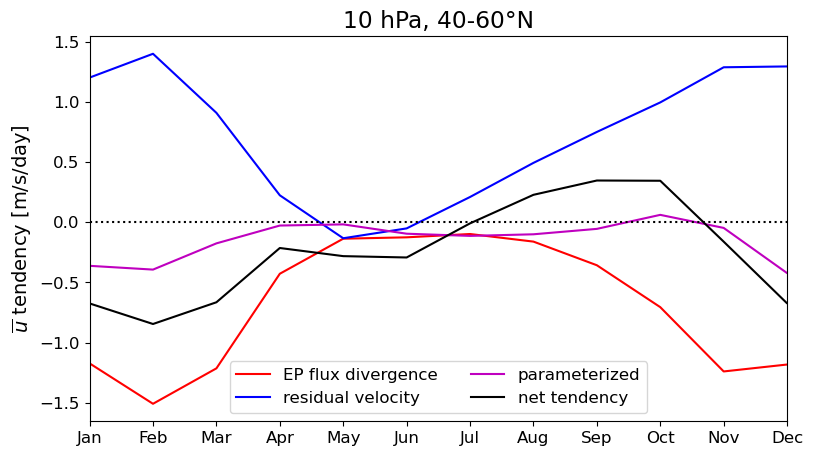

In [38]:
utepfd = climo['utendepfd'].sel(lat=slice(40, 60)).mean('lat').sel(plev=12, method='nearest') * (60*60*24)
utrv = climo['utendresvel'].sel(lat=slice(40, 60)).mean('lat').sel(plev=12, method='nearest') * (60*60*24)
utgw = climo['utendgw'].sel(lat=slice(40, 60)).mean('lat').sel(plev=12, method='nearest') * (60*60*24)
utdf = climo['utenddiff'].sel(lat=slice(40, 60)).mean('lat').sel(plev=12, method='nearest') * (60*60*24)
uttot = utepfd+utrv+utgw+utdf
plt.figure(figsize=(9,5))
plt.plot(utepfd.month, utepfd, '-r', label='EP flux divergence')
plt.plot(utepfd.month, utrv, '-b', label='residual velocity')
plt.plot(utepfd.month, utgw, '-m', label='parameterized')
plt.plot(utepfd.month, uttot, '-k', label='net tendency')
plt.gca().axhline(y=0, ls=':', color='k')
plt.legend(loc='lower center', ncol=2)
plt.title('10 hPa, 40-60°N')
plt.gca().set_ylabel('$\\overline{{u}}$ tendency [m/s/day]')
plt.gca().set_xlim([1, 12])
plt.gca().xaxis.set_ticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.gca().xaxis.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig('balance.png')
plt.show()